In [3]:
from socceraction.data.statsbomb import StatsBombLoader
import pandas as pd
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import tqdm
import warnings
from tqdm_joblib import tqdm_joblib as tqdm_callback
from joblib import Parallel, delayed
import os

/Users/jeangrifnee/PycharmProjects/Valuing/.venv/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('future.no_silent_downcasting', True)  # empêche les downcasting implicites
 
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")


In [6]:
data_root = "../data"
SBL = StatsBombLoader(getter="local",root=data_root)

In [7]:
competitions = SBL.competitions()
set(competitions.competition_name)

{'1. Bundesliga',
 'African Cup of Nations',
 'Champions League',
 'Copa America',
 'Copa del Rey',
 "FA Women's Super League",
 'FIFA U20 World Cup',
 'FIFA World Cup',
 'Indian Super league',
 'La Liga',
 'Liga Profesional',
 'Ligue 1',
 'Major League Soccer',
 'NWSL',
 'North American League',
 'Premier League',
 'Serie A',
 'UEFA Euro',
 'UEFA Europa League',
 "UEFA Women's Euro",
 "Women's World Cup"}

In [8]:
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in competitions.itertuples()
])

games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,904,176,2024-04-14 17:30:00,5,0
1,190,904,2024-04-06 15:30:00,0,1
2,184,904,2024-05-05 18:30:00,1,5
3,868,904,2024-05-12 20:30:00,0,5
4,904,172,2024-05-18 16:30:00,2,1
...,...,...,...,...,...
47,852,865,2019-06-27 21:00:00,0,3
48,865,1214,2019-07-02 21:00:00,1,2
49,851,858,2019-07-03 21:00:00,1,0
50,855,851,2019-06-29 15:00:00,0,2


In [9]:
import tqdm
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}
for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    # convert data
    actions[game.game_id] = spadl.statsbomb.convert_to_actions(
        events, 
        home_team_id=game.home_team_id,
        xy_fidelity_version=1,
        shot_fidelity_version=1
    )

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

Loading game data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3433/3433 [15:01<00:00,  3.81it/s]


In [11]:
datafolder = "../data-fifa"


# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb3.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]

/var/folders/96/kln5y_yd4qs3jyq6jtwnbl3h0000gn/T/ipykernel_46989/1496087964.py:14: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['competition_stage', 'venue', 'referee'], dtype='object')]

  spadlstore["games"] = games
/var/folders/96/kln5y_yd4qs3jyq6jtwnbl3h0000gn/T/ipykernel_46989/1496087964.py:16: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['player_name', 'nickname'], dtype='object')]

  spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
/var/folders/96/kln5y_yd4qs3jyq6jtwnbl3h0000gn/T/ipykernel_46989/1496087964.py:19: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type

In [12]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.competition_name == "FIFA World Cup") 
                  & (games.away_team_name == "England")
                  & (games.home_team_name == "Belgium")]
    game_id = game.game_id.values[0]
    actions = (
        spadlstore[f"actions/game_{game_id}"]
        .merge(spadl.actiontypes_df(), how="left")
        .merge(spadl.results_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)
del actions['nickname']
actions[:5]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,team_name
0,8657,84438495-6341-4eba-bf90-82db1f6703fb,1,0.533,782,3289.0,52.9375,33.575,44.1875,33.575,0,1,5,0,pass,success,foot_right,Romelu Lukaku,Belgium
1,8657,6f02abb4-0b81-4531-be11-6bf6ea7e695b,1,1.252,782,5642.0,44.1875,33.575,44.1875,34.425,21,1,0,1,dribble,success,foot,Axel Witsel,Belgium
2,8657,34b355a6-8b5f-4954-8dfd-fcc77df5c40c,1,2.133,782,5642.0,44.1875,34.425,31.9375,53.125,0,1,5,2,pass,success,foot_right,Axel Witsel,Belgium
3,8657,29b70f75-5970-491c-acc7-5dbfb353200c,1,3.732,782,3077.0,31.9375,53.125,28.4375,53.125,21,1,0,3,dribble,success,foot,Jan Vertonghen,Belgium
4,8657,8fd1ffd0-b984-4823-ab2c-f249c04adc12,1,4.933,782,3077.0,28.4375,53.125,24.0625,38.675,0,1,4,4,pass,success,foot_left,Jan Vertonghen,Belgium


2018-07-14 16:00:00 Belgium 2-0 England 82'


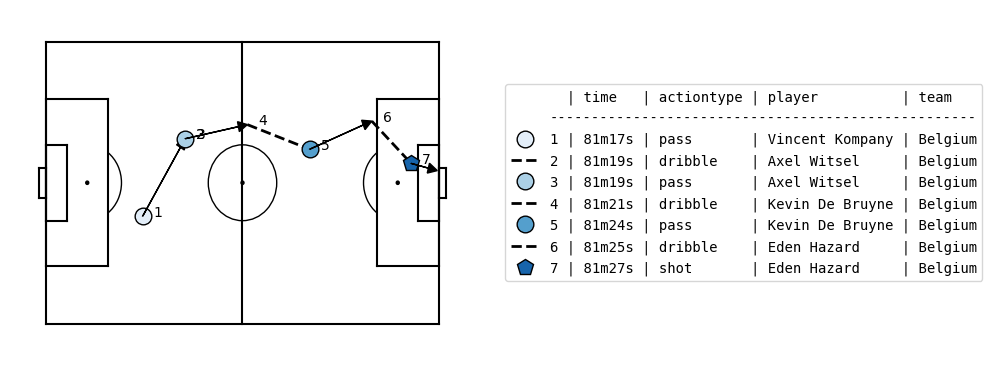

In [13]:
import matplotsoccer
import matplotlib
# Select the 5 actions preceding the 2-0
shot = 2201
a = actions[shot-8:shot-1].copy()

# Print the game date and timestamp of the goal
g = game.iloc[0]
minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
print(game_info)

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "type_name", "player_name", "team_name"]]

ax = matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False,
    figsize=6
)

In [53]:
from tqdm import tqdm
from socceraction import spadl

actions_all = []
failed = []

with pd.HDFStore(spadl_h5) as spadlstore:
    # Charger les métadonnées de match
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix("home_"), how='left')
        .merge(spadlstore["teams"].add_prefix("away_"), how='left')
    )

    for game_id in tqdm(games["game_id"], desc="Chargement actions par match"):
        try:
            actions = (
                spadlstore[f"actions/game_{game_id}"]
                .merge(spadl.actiontypes_df(), how="left")
                .merge(spadl.results_df(), how="left")
                .merge(spadl.bodyparts_df(), how="left")
                .merge(spadlstore["players"], how="left")
                .merge(spadlstore["teams"], how="left")
            )
            actions["game_id"] = game_id
            actions_all.append(actions)
        except KeyError:
            print(f"⚠️ Match manquant dans HDF5 : {game_id}")
            failed.append(game_id)

# Concaténation finale
actions = pd.concat(actions_all, ignore_index=True)

# Gestion du nom du joueur (si "nickname" existe)
if "nickname" in actions.columns:
    actions["player_name"] = actions[["nickname", "player_name"]].apply(
        lambda x: x.iloc[0] if pd.notnull(x.iloc[0]) else x.iloc[1], axis=1
    )
    del actions["nickname"]

print(f"\n✅ Chargement terminé : {len(actions)} actions sur {len(games)} matchs")
if failed:
    print(f"⚠️ {len(failed)} matchs n'ont pas pu être chargés")

Chargement actions par match: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3433/3433 [00:54<00:00, 62.97it/s]



✅ Chargement terminé : 6944912 actions sur 3433 matchs


In [54]:
from datetime import datetime

# 📊 1.1 – Taille et structure
print(f"✅ Nombre total d’actions : {actions.shape[0]}")
print(f"📄 Nombre de colonnes : {actions.shape[1]}")
print("🔢 Liste des colonnes :", list(actions.columns))

# 👥 1.2 – Joueurs, équipes, matchs uniques
n_games = actions["game_id"].nunique()
n_players = actions["player_id"].nunique()
n_teams = actions["team_id"].nunique()
print(f"\n🧠 Nombre de matchs uniques : {n_games}")
print(f"👥 Nombre de joueurs uniques : {n_players}")
print(f"🏳️ Nombre d’équipes uniques : {n_teams}")

# 🧼 1.3 – Valeurs manquantes
missing = actions.isna().mean().sort_values(ascending=False)
missing = missing[missing > 0]
print("\n🧼 Valeurs manquantes :")
if missing.empty:
    print("✅ Aucun NaN détecté 🎉")
else:
    print((missing * 100).round(2).astype(str) + ' %')

# 📐 1.4 – Vérification des coordonnées
print("\n📍 Coordonnées SPADL :")
for coord in ["start_x", "end_x"]:
    print(f"{coord} min/max :", actions[coord].min(), "/", actions[coord].max())
for coord in ["start_y", "end_y"]:
    print(f"{coord} min/max :", actions[coord].min(), "/", actions[coord].max())

# 📅 1.5 – Période temporelle couverte
games["game_date"] = pd.to_datetime(games["game_date"])
print(f"\n📅 Période couverte : {games['game_date'].min().date()} → {games['game_date'].max().date()}")

# 🏆 1.6 – Compétitions disponibles
print("\n🏆 Compétitions les plus présentes :")
print(games["competition_name"].value_counts().head(10))


✅ Nombre total d’actions : 6944912
📄 Nombre de colonnes : 19
🔢 Liste des colonnes : ['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id', 'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id', 'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name', 'bodypart_name', 'player_name', 'team_name']

🧠 Nombre de matchs uniques : 3433
👥 Nombre de joueurs uniques : 8925
🏳️ Nombre d’équipes uniques : 310

🧼 Valeurs manquantes :
original_event_id    2.33 %
dtype: object

📍 Coordonnées SPADL :
start_x min/max : 0.0 / 105.0
end_x min/max : 0.0 / 105.0
start_y min/max : 0.0 / 68.0
end_y min/max : 0.0 / 68.0

📅 Période couverte : 1958-06-24 → 2024-07-15

🏆 Compétitions les plus présentes :
competition_name
La Liga                    868
Ligue 1                    435
Premier League             418
Serie A                    381
1. Bundesliga              340
FA Women's Super League    326
FIFA World Cup             147
Women's World Cup          116
Indian Sup

In [56]:
import os, json
from glob import glob

# Charger tous les fichiers JSON dans data/three-sixty
three_sixty_files = glob("data/three-sixty/*.json")

# Parser les JSON
ts_data = []
for path in tqdm(three_sixty_files, desc="Chargement données 360"):
    with open(path, "r") as f:
        match_data = json.load(f)
        ts_data.extend(match_data)  # chaque fichier contient plusieurs frames

# En DataFrame
df_360 = pd.DataFrame(ts_data)
df_360.rename(columns={"event_uuid": "original_event_id"}, inplace=True)

Chargement données 360: 0it [00:00, ?it/s]


In [61]:
import os, json
from glob import glob

# Charger tous les fichiers JSON dans data/three-sixty
three_sixty_files = glob("../data/three-sixty/*.json")

# Parser les JSON
ts_data = []

corrupted_files = []
for path in tqdm(three_sixty_files, desc="Chargement données 360"):
    try:
        with open(path, "r") as f:
            match_data = json.load(f)
            ts_data.extend(match_data)
    except json.JSONDecodeError as e:
        print(f"⚠️ JSON corrompu : {path} → {e}")
        corrupted_files.append(path)

print(f"✅ Chargement terminé ({len(ts_data)} frames) – Fichiers ignorés : {len(corrupted_files)}")


# En DataFrame
df_360 = pd.DataFrame(ts_data)
df_360.rename(columns={"event_uuid": "original_event_id"}, inplace=True)

Chargement données 360:   5%|███████▋                                                                                                                                     | 16/295 [00:00<00:16, 17.30it/s]

⚠️ JSON corrompu : ../data/three-sixty/3835338.json → Expecting value: line 181321 column 20 (char 5193728)


Chargement données 360:  25%|██████████████████████████████████▉                                                                                                          | 73/295 [00:04<00:09, 22.87it/s]

⚠️ JSON corrompu : ../data/three-sixty/3835342.json → Expecting ',' delimiter: line 171856 column 109 (char 4882432)


Chargement données 360:  69%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 204/295 [00:11<00:05, 15.80it/s]

⚠️ JSON corrompu : ../data/three-sixty/3845506.json → Expecting ',' delimiter: line 92794 column 3 (char 2637824)


Chargement données 360: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [00:15<00:00, 18.92it/s]


✅ Chargement terminé (937186 frames) – Fichiers ignorés : 3


In [62]:
print(df_360.head(5))

                      original_event_id  \
0  75d6cc25-b03b-44e0-9c50-99a7e3c47315   
1  ec457cc8-050c-4884-abbc-1e85bc3c83dc   
2  246b93aa-3831-4b07-a51e-b6ba578e60d5   
3  eda20fee-cab0-4094-aba3-ae286ef64004   
4  e8a3f021-76da-443b-9a1d-c5857c486493   

                                        visible_area  \
0  [29.574167858721, 80.0, 47.7992071074168, 0.0,...   
1  [29.5261908068648, 80.0, 47.3846276547738, 0.0...   
2  [27.6350829489137, 80.0, 45.4935197968227, 0.0...   
3  [13.8331181325244, 80.0, 40.2628933325614, 6.1...   
4  [13.8331181325244, 80.0, 40.2628933325614, 6.1...   

                                        freeze_frame  
0  [{'teammate': True, 'actor': False, 'keeper': ...  
1  [{'teammate': True, 'actor': False, 'keeper': ...  
2  [{'teammate': True, 'actor': False, 'keeper': ...  
3  [{'teammate': True, 'actor': True, 'keeper': F...  
4  [{'teammate': True, 'actor': True, 'keeper': F...  


In [64]:
actions_merged = actions.merge(
    df_360,
    on="original_event_id",
    how="left"
)

In [65]:
print(actions_merged.head(5))

   game_id                     original_event_id  period_id  time_seconds  \
0  3895302  221b0c8d-6386-4ae8-bb4a-a1dc98742312          1         3.417   
1  3895302  77809242-1460-4395-8779-94a0cfc275b1          1         3.870   
2  3895302  ff56e821-21e9-4cef-ba2a-7eb5eb3769c6          1         4.732   
3  3895302  cf9088bc-7e59-4d57-8ac5-31658da858bb          1         6.728   
4  3895302  4464cb75-f45f-4508-8444-2560d1625d06          1         7.622   

   team_id  player_id  start_x  start_y    end_x   end_y  ...  result_id  \
0      176    34870.0  52.0625   33.660  53.8125  34.340  ...          1   
1      176    12299.0  53.8125   34.340  53.8125  34.085  ...          1   
2      176    12299.0  53.8125   34.085  74.7250  36.295  ...          1   
3      176    31100.0  74.7250   36.295  74.7250  36.720  ...          1   
4      176    31100.0  74.7250   36.720  76.3875  53.805  ...          1   

   bodypart_id  action_id  type_name result_name bodypart_name  \
0            5

In [66]:
from datetime import datetime
import pandas as pd

# 📊 1.1 – Taille et structure
print(f"✅ Nombre total d’actions : {actions_merged.shape[0]}")
print(f"📄 Nombre de colonnes : {actions_merged.shape[1]}")
print("🔢 Liste des colonnes :", list(actions_merged.columns))

# 👥 1.2 – Joueurs, équipes, matchs uniques
n_games = actions_merged["game_id"].nunique()
n_players = actions_merged["player_id"].nunique()
n_teams = actions_merged["team_id"].nunique()
print(f"\n🧠 Nombre de matchs uniques : {n_games}")
print(f"👥 Nombre de joueurs uniques : {n_players}")
print(f"🏳️ Nombre d’équipes uniques : {n_teams}")

# 🧼 1.3 – Valeurs manquantes
missing = actions_merged.isna().mean().sort_values(ascending=False)
missing = missing[missing > 0]
print("\n🧼 Valeurs manquantes :")
if missing.empty:
    print("✅ Aucun NaN détecté 🎉")
else:
    print((missing * 100).round(2).astype(str) + ' %')

# 📐 1.4 – Vérification des coordonnées SPADL
print("\n📍 Coordonnées SPADL :")
for coord in ["start_x", "end_x"]:
    print(f"{coord} min/max :", actions_merged[coord].min(), "/", actions_merged[coord].max())
for coord in ["start_y", "end_y"]:
    print(f"{coord} min/max :", actions_merged[coord].min(), "/", actions_merged[coord].max())

# 📅 1.5 – Période temporelle couverte
if "game_date" in games.columns:
    games["game_date"] = pd.to_datetime(games["game_date"], errors='coerce')
    print(f"\n📅 Période couverte : {games['game_date'].min().date()} → {games['game_date'].max().date()}")

# 🏆 1.6 – Compétitions les plus présentes
print("\n🏆 Compétitions les plus présentes :")
print(games["competition_name"].value_counts().head(10))

# 🧊 1.7 – Disponibilité des données 360
ff_rate = actions_merged["freeze_frame"].notna().mean()
print(f"\n🧊 Pourcentage d’actions avec freeze_frame : {(ff_rate * 100):.2f} %")
va_rate = actions_merged["visible_area"].notna().mean()
print(f"👁️ Pourcentage d’actions avec visible_area : {(va_rate * 100):.2f} %")


✅ Nombre total d’actions : 6944912
📄 Nombre de colonnes : 21
🔢 Liste des colonnes : ['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id', 'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id', 'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name', 'bodypart_name', 'player_name', 'team_name', 'visible_area', 'freeze_frame']

🧠 Nombre de matchs uniques : 3433
👥 Nombre de joueurs uniques : 8925
🏳️ Nombre d’équipes uniques : 310

🧼 Valeurs manquantes :
freeze_frame         92.27 %
visible_area         92.27 %
original_event_id     2.33 %
dtype: object

📍 Coordonnées SPADL :
start_x min/max : 0.0 / 105.0
end_x min/max : 0.0 / 105.0
start_y min/max : 0.0 / 68.0
end_y min/max : 0.0 / 68.0

📅 Période couverte : 1958-06-24 → 2024-07-15

🏆 Compétitions les plus présentes :
competition_name
La Liga                    868
Ligue 1                    435
Premier League             418
Serie A                    381
1. Bundesliga              340
FA Women's S

🏆 Pourcentage de couverture freeze_frame par compétition :
competition_name
UEFA Euro                  85.95 %
UEFA Women's Euro          79.85 %
Women's World Cup          48.09 %
FIFA World Cup             39.17 %
1. Bundesliga              10.07 %
FA Women's Super League      0.0 %
FIFA U20 World Cup           0.0 %
Copa del Rey                 0.0 %
Indian Super league          0.0 %
La Liga                      0.0 %
African Cup of Nations       0.0 %
Ligue 1                      0.0 %
Major League Soccer          0.0 %
NWSL                         0.0 %
North American League        0.0 %
Premier League               0.0 %
Serie A                      0.0 %
Copa America                 0.0 %
UEFA Europa League           0.0 %
Champions League             0.0 %
Liga Profesional             0.0 %
Name: freeze_frame, dtype: object

📈 Top 10 matchs les mieux couverts (freeze_frame) :
game_id
3788759    91.95 %
3857286    91.87 %
3788745    91.83 %
3930182    91.26 %
3869220    91.15 %

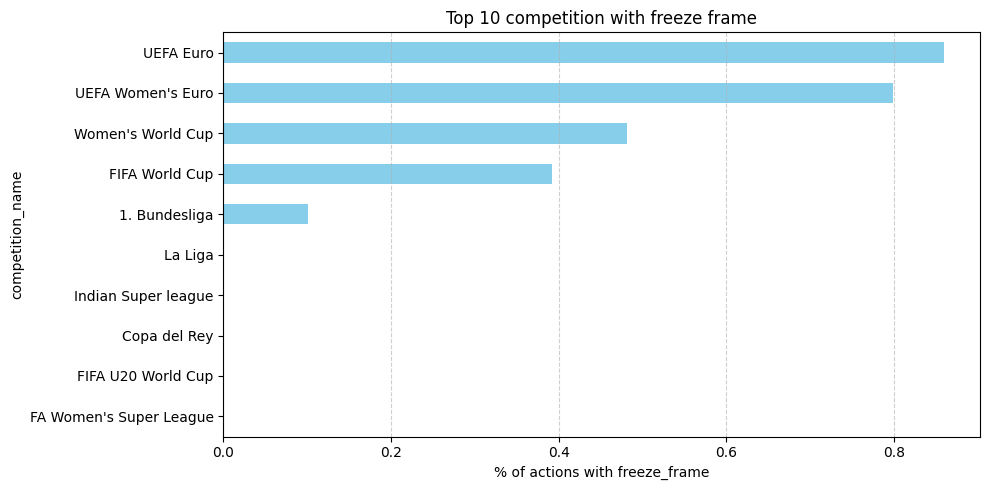

In [75]:
# 📦 Étape 2 – Analyse de la couverture des données 360

import matplotlib.pyplot as plt
actions_merged = actions_merged.merge(
    games[["game_id", "competition_name", "season_id", "game_date"]],
    on="game_id",
    how="left"
)
# 2.1 – % d’actions avec freeze_frame par compétition
coverage_by_comp = (
    actions_merged.groupby("competition_name")["freeze_frame"]
    .apply(lambda x: x.notna().mean())
    .sort_values(ascending=False)
)

print("🏆 Pourcentage de couverture freeze_frame par compétition :")
print((coverage_by_comp * 100).round(2).astype(str) + " %")

# 2.2 – % d’actions avec freeze_frame par match (top 10 / bottom 10)
coverage_by_game = (
    actions_merged.groupby("game_id")["freeze_frame"]
    .apply(lambda x: x.notna().mean())
)

top_games = coverage_by_game.sort_values(ascending=False).head(10)
bottom_games = coverage_by_game.sort_values().head(10)

print("\n📈 Top 10 matchs les mieux couverts (freeze_frame) :")
print((top_games * 100).round(2).astype(str) + " %")

print("\n📉 Bottom 10 matchs les moins couverts (freeze_frame) :")
print((bottom_games * 100).round(2).astype(str) + " %")

# 2.3 – Si disponible : couverture par saison
if "season_id" in games.columns:
    game_season = games.set_index("game_id")["season_id"]
    actions_merged["season_id"] = actions_merged["game_id"].map(game_season)

    coverage_by_season = (
        actions_merged.groupby("season_id")["freeze_frame"]
        .apply(lambda x: x.notna().mean())
        .sort_values(ascending=False)
    )
    print("\n📆 Couverture freeze_frame par saison :")
    print((coverage_by_season * 100).round(2).astype(str) + " %")

# 2.4 – Visualisation : top compétitions
plt.figure(figsize=(10, 5))
coverage_by_comp.head(10).sort_values().plot(kind="barh", color="skyblue")
plt.xlabel("% of actions with freeze_frame")
plt.title("Top 10 competition with freeze frame")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [73]:
# 📌 Étape 1 : Sélectionner les matchs avec bonne couverture
coverage = actions_merged.groupby("game_id")["freeze_frame"].apply(lambda x: x.notna().mean())
selected_game_ids = coverage[coverage > 0.8].index

# 📌 Étape 2 : Filtrer les actions avec bonne couverture 360
actions_360 = actions_merged[actions_merged["game_id"].isin(selected_game_ids)].copy()

# 📊 Étape 3 : Résumé du sous-dataset
n_actions = len(actions_360)
n_goals = actions_360.query("type_name == 'shot' and result_name == 'success'").shape[0]
n_players = actions_360["player_id"].nunique()
n_games = actions_360["game_id"].nunique()
n_teams = actions_360["team_id"].nunique()
time_range = games[games["game_id"].isin(selected_game_ids)]["game_date"]
coverage_mean = actions_360["freeze_frame"].notna().mean() * 100

print(f"📦 Nombre d’actions conservées : {n_actions:,}")
print(f"⚽ Nombre de buts détectés     : {n_goals}")
print(f"👥 Nombre de joueurs uniques   : {n_players}")
print(f"🧠 Nombre de matchs sélectionnés : {n_games}")
print(f"🏳 Nombre d’équipes uniques    : {n_teams}")
print(f"🕰️ Période couverte            : {time_range.min().date()} → {time_range.max().date()}")
print(f"🎯 Taux de freeze_frame moyen  : {coverage_mean:.2f} %")

# 🔍 Étape 4 : Analyse des trous
missing_ff = actions_360[actions_360["freeze_frame"].isna()]
missing_ff["action_index"] = missing_ff.groupby("game_id").cumcount()

print(f"\n🕳️ Nombre d’actions sans freeze_frame dans ce sous-dataset : {len(missing_ff)}")

# Vérif : ces actions sont-elles isolées ?
before = actions_360.shift(1)
after = actions_360.shift(-1)
missing_ff["prev_has_ff"] = before["freeze_frame"].notna()
missing_ff["next_has_ff"] = after["freeze_frame"].notna()

interp_possible = (missing_ff["prev_has_ff"] & missing_ff["next_has_ff"]).mean()
print(f"🩹 Pourcentage des actions manquantes avec contexte temporel exploitable (avant ET après dispo) : {interp_possible * 100:.2f} %")


📦 Nombre d’actions conservées : 605,110
⚽ Nombre de buts détectés     : 655
👥 Nombre de joueurs uniques   : 2253
🧠 Nombre de matchs sélectionnés : 283
🏳 Nombre d’équipes uniques    : 103
🕰️ Période couverte            : 2021-06-11 → 2024-07-14
🎯 Taux de freeze_frame moyen  : 86.36 %

🕳️ Nombre d’actions sans freeze_frame dans ce sous-dataset : 82537
🩹 Pourcentage des actions manquantes avec contexte temporel exploitable (avant ET après dispo) : 35.87 %


/var/folders/96/kln5y_yd4qs3jyq6jtwnbl3h0000gn/T/ipykernel_14009/1671772755.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ff["action_index"] = missing_ff.groupby("game_id").cumcount()
/var/folders/96/kln5y_yd4qs3jyq6jtwnbl3h0000gn/T/ipykernel_14009/1671772755.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ff["prev_has_ff"] = before["freeze_frame"].notna()
/var/folders/96/kln5y_yd4qs3jyq6jtwnbl3h0000gn/T/ipykernel_14009/1671772755.py:35: SettingWithCopyWarning: 
A value is trying

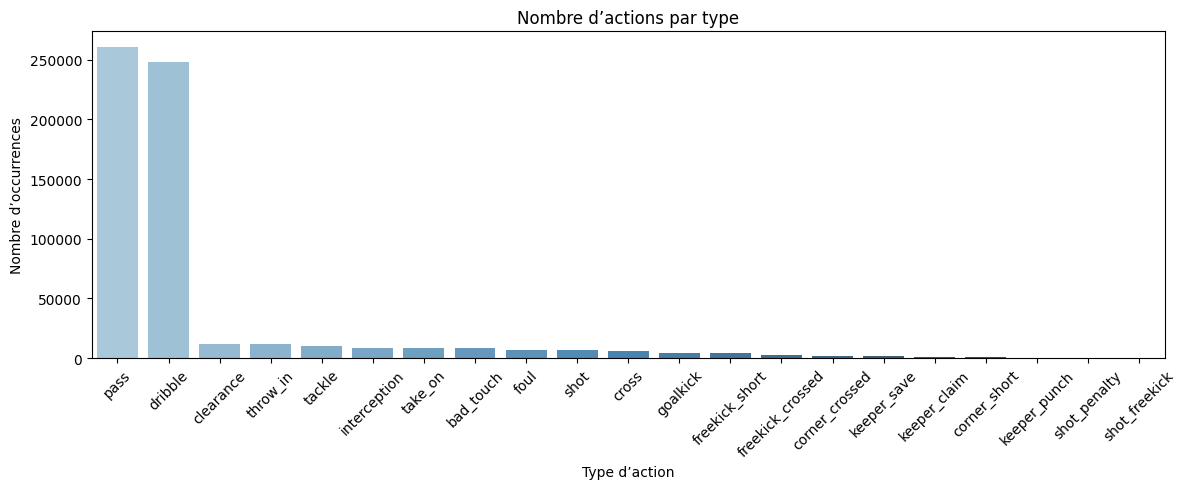

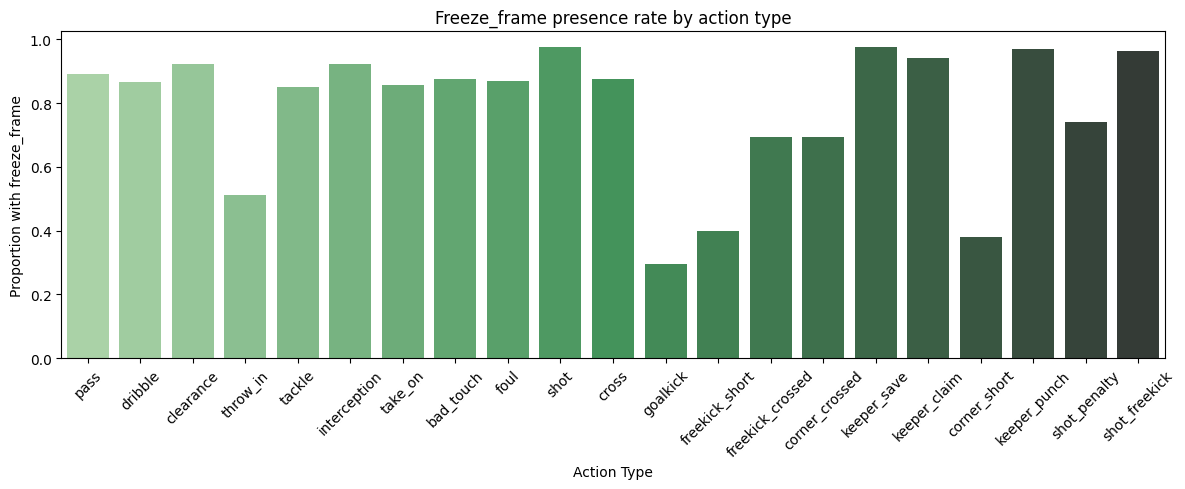

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔢 Comptage des types d’actions
action_counts = actions_360["type_name"].value_counts().sort_values(ascending=False)
action_counts.name = "count"

# 🎯 Proportion avec freeze_frame
ff_rate = actions_360.groupby("type_name")["freeze_frame"].apply(lambda x: x.notna().mean())
ff_rate.name = "ff_rate"

# 📊 Fusion
action_stats = pd.concat([action_counts, ff_rate], axis=1).reset_index().rename(columns={"index": "type_name"})

# 📈 Visualisation : histogramme du nombre d’actions
plt.figure(figsize=(12, 5))
sns.barplot(data=action_stats, x="type_name", y="count", palette="Blues_d")
plt.xticks(rotation=45)
plt.title("Nombre d’actions par type")
plt.xlabel("Type d’action")
plt.ylabel("Nombre d’occurrences")
plt.tight_layout()
plt.show()

# 📈 Visualisation : taux de freeze_frame par type
plt.figure(figsize=(12, 5))
sns.barplot(data=action_stats, x="type_name", y="ff_rate", palette="Greens_d")
plt.xticks(rotation=45)
plt.title("Freeze_frame presence rate by action type")
plt.xlabel("Action Type")
plt.ylabel("Proportion with freeze_frame")
plt.tight_layout()
plt.show()



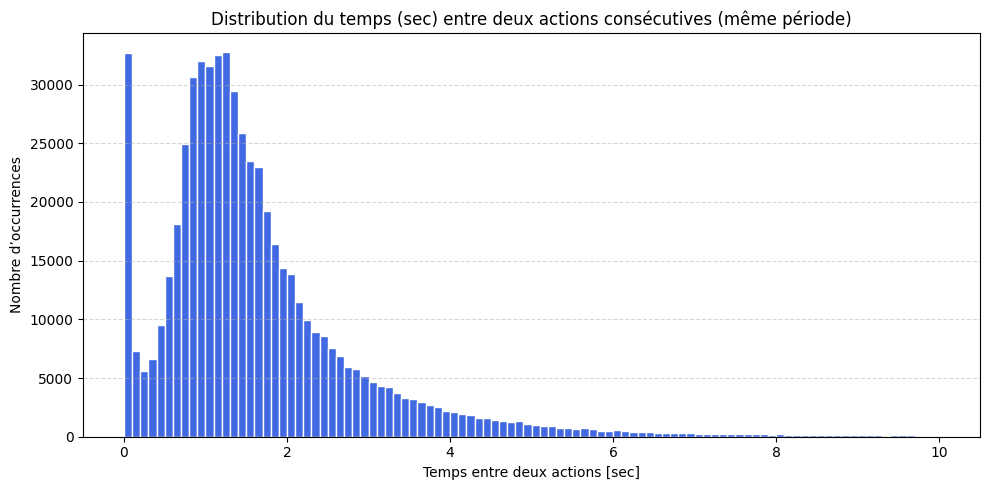

📊 Moyenne : 1.64 sec
📉 Médiane : 1.34 sec
📈 95e percentile : 4.12 sec


In [95]:
import matplotlib.pyplot as plt

# 🧼 Tri par match, période, temps
actions_sorted = actions_360.sort_values(by=["game_id", "period_id", "time_seconds"])

# ⏱️ Différence temporelle entre actions consécutives dans la même mi-temps
actions_sorted["time_diff"] = actions_sorted.groupby(["game_id", "period_id"])["time_seconds"].diff()

# 🔍 On enlève les premières actions de chaque période
time_diffs = actions_sorted["time_diff"].dropna()
time_diffs = time_diffs[time_diffs < 10]
# 📈 Histogramme
plt.figure(figsize=(10, 5))
plt.hist(time_diffs, bins=100, color="royalblue", edgecolor="white")
plt.title("Distribution du temps (sec) entre deux actions consécutives (même période)")
plt.xlabel("Temps entre deux actions [sec]")
plt.ylabel("Nombre d’occurrences")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 🧠 Stats descriptives
print(f"📊 Moyenne : {time_diffs.mean():.2f} sec")
print(f"📉 Médiane : {time_diffs.median():.2f} sec")
print(f"📈 95e percentile : {time_diffs.quantile(0.95):.2f} sec")



/var/folders/96/kln5y_yd4qs3jyq6jtwnbl3h0000gn/T/ipykernel_14009/3191183884.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_zero = df_zero[same_game & same_period]


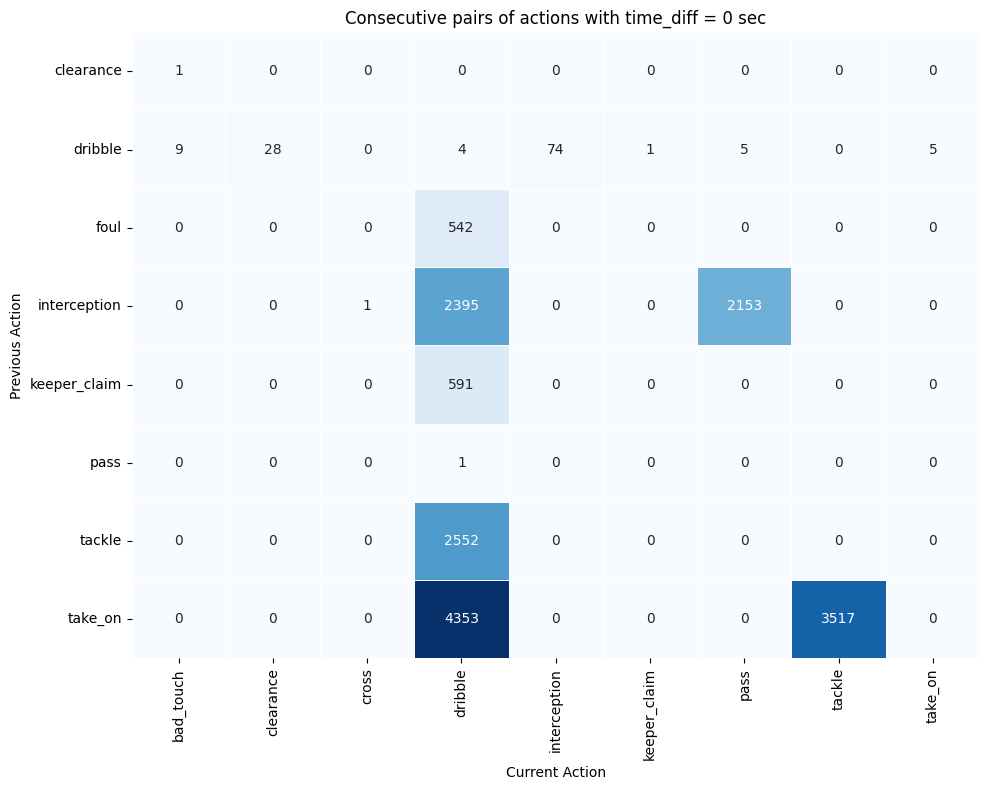

In [98]:
# ➕ Actions consécutives avec time_diff = 0
df_zero = actions_sorted[actions_sorted["time_diff"] == 0].copy()

# ➕ Ajoute les types d’action précédent(e)s
df_zero["prev_type"] = actions_sorted["type_name"].shift(1)

# ➕ Supprime les cas où les deux actions ne sont pas dans la même période ou même match
same_game = actions_sorted["game_id"] == actions_sorted["game_id"].shift(1)
same_period = actions_sorted["period_id"] == actions_sorted["period_id"].shift(1)
df_zero = df_zero[same_game & same_period]

# ➕ Matrice croisée (comptage des paires d’actions à 0 sec)
cross = pd.crosstab(df_zero["prev_type"], df_zero["type_name"])

# ➕ Affichage
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cross, cmap="Blues", annot=True, fmt="d", linewidths=0.5, cbar=False)
plt.title("Consecutive pairs of actions with time_diff = 0 sec")
plt.xlabel("Current Action")
plt.ylabel("Previous Action")
plt.tight_layout()
plt.show()


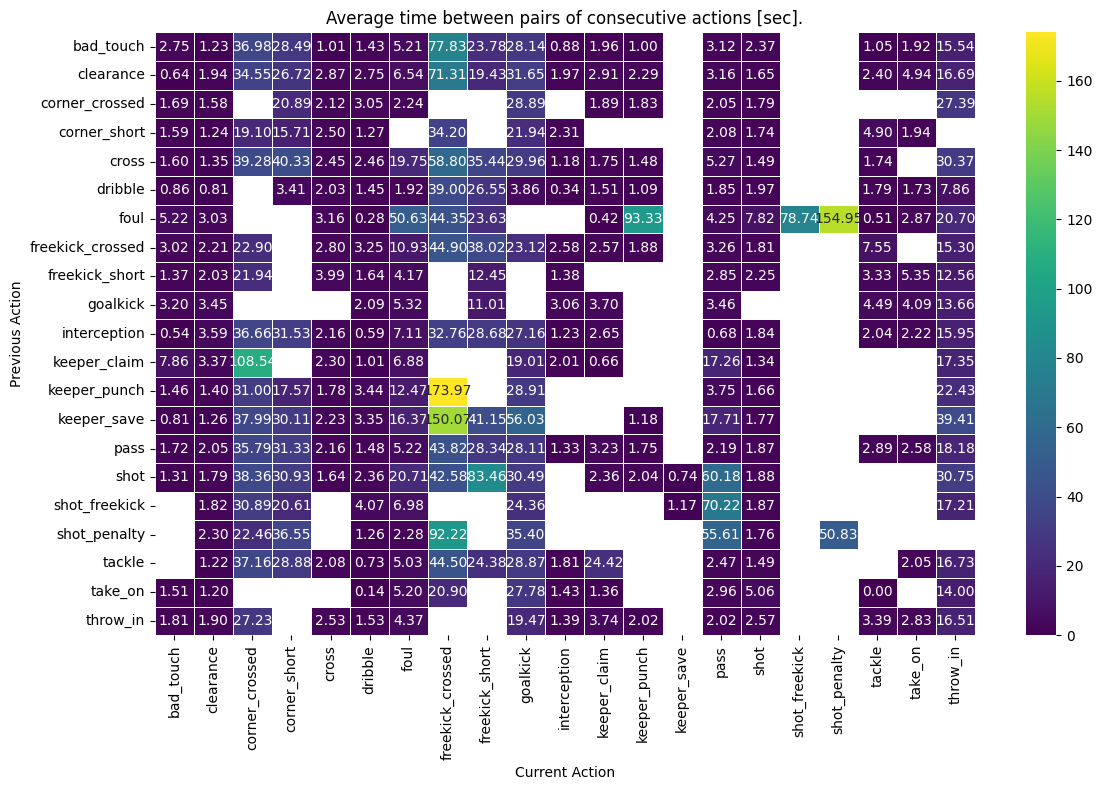

In [101]:
# 🔄 On recalcule le time_diff entre actions consécutives du même match et même période
actions_sorted["prev_type"] = actions_sorted["type_name"].shift(1)
actions_sorted["prev_game"] = actions_sorted["game_id"].shift(1)
actions_sorted["prev_period"] = actions_sorted["period_id"].shift(1)

# 🎯 Garde uniquement les actions consécutives valides (même match & période)
valid = (actions_sorted["game_id"] == actions_sorted["prev_game"]) & \
        (actions_sorted["period_id"] == actions_sorted["prev_period"])

df_valid = actions_sorted[valid].copy()

# 📊 Moyenne des time_diff par paire d’action
pivot_mean = df_valid.pivot_table(
    index="prev_type",
    columns="type_name",
    values="time_diff",
    aggfunc="mean"
)

# 📉 Affichage heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_mean, cmap="viridis", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Average time between pairs of consecutive actions [sec].")
plt.xlabel("Current Action")
plt.ylabel("Previous Action")
plt.tight_layout()
plt.show()


In [111]:
import numpy as np
def normalize_point(x, y):
    return x * 105 / 120, y * 68 / 80
def normalize_visible_area(area):
    if isinstance(area, list):
        coords = np.array(area).reshape(-1, 2)
        coords_norm = [normalize_point(x, y) for x, y in coords]
        return coords_norm
    return np.nan

actions_360["visible_area"] = actions_360["visible_area"].apply(normalize_visible_area)
def normalize_freeze_frame(ff):
    if isinstance(ff, list):
        for p in ff:
            x, y = p.get("x"), p.get("y")
            if x is not None and y is not None:
                x_new, y_new = normalize_point(x, y)
                p["x"], p["y"] = x_new, y_new
        return ff
    return np.nan

actions_360["freeze_frame"] = actions_360["freeze_frame"].apply(normalize_freeze_frame)

start_x: min = 0.0, max = 105.0
end_x: min = 0.0, max = 105.0
start_y: min = 0.0, max = 68.0
end_y: min = 0.0, max = 68.0


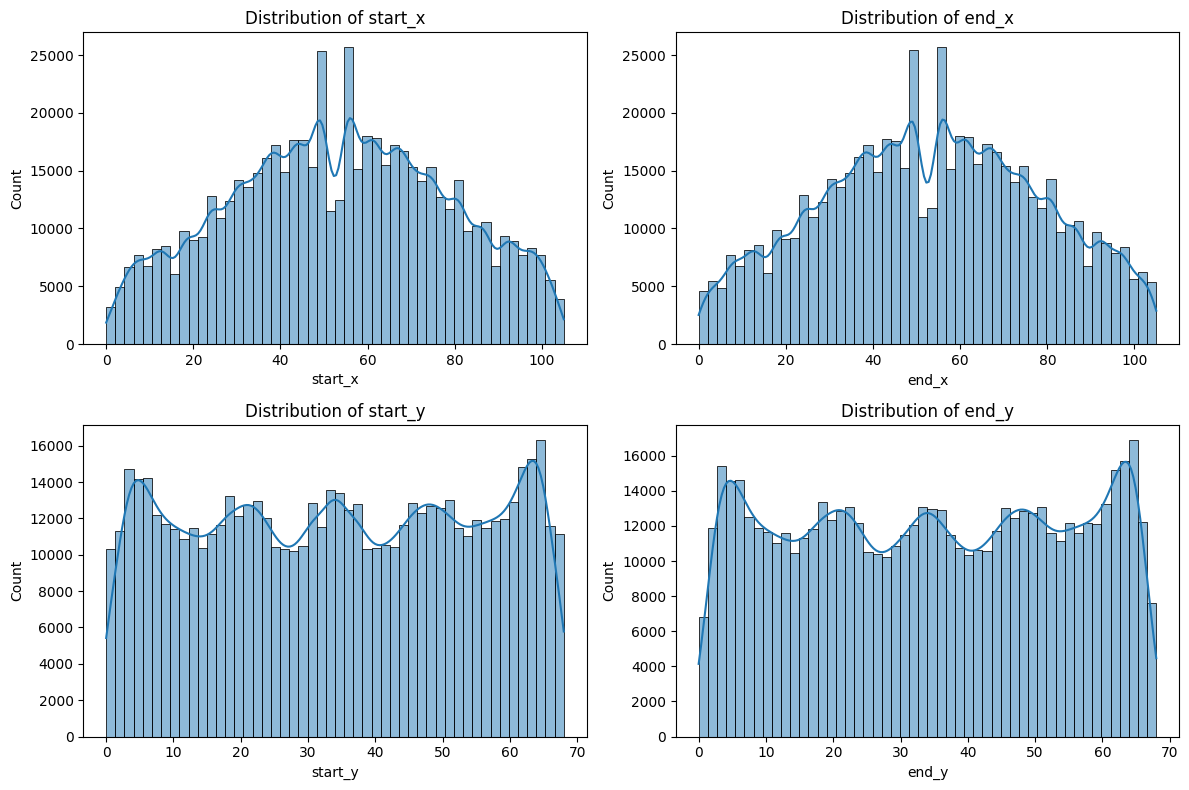

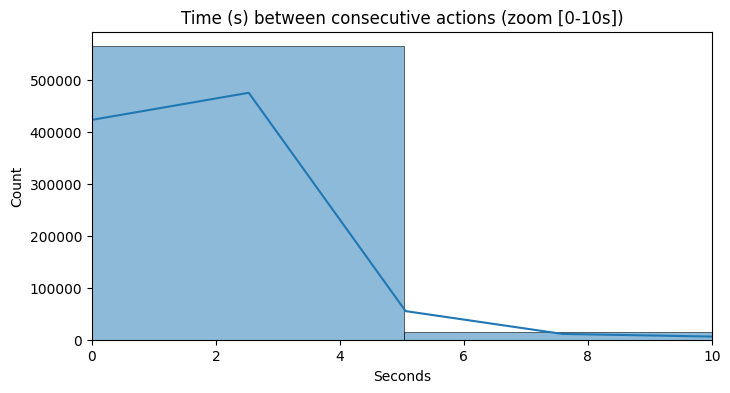

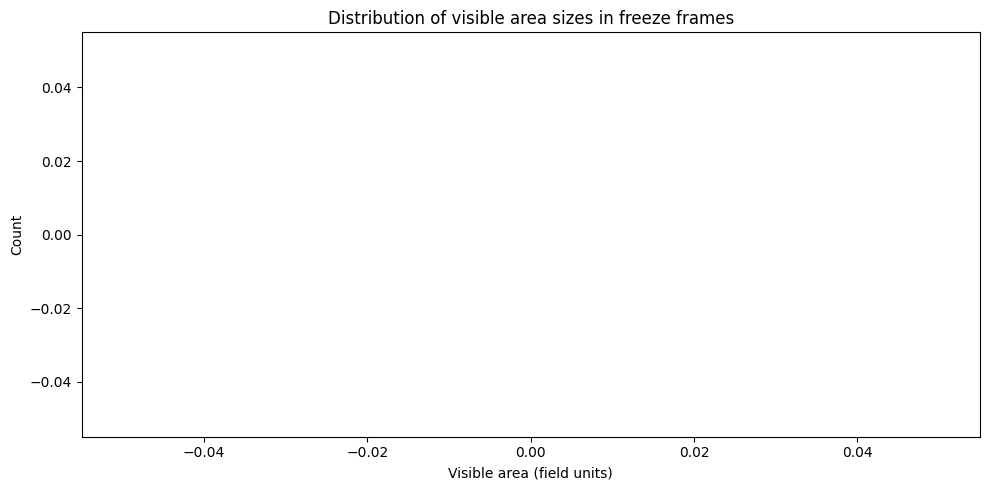

📐 Min : nan
📏 Max : nan
📊 Moyenne : nan


In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Coordonnées SPADL (start_x, end_x, start_y, end_y)
coord_cols = ["start_x", "end_x", "start_y", "end_y"]
for col in coord_cols:
    print(f"{col}: min = {actions_360[col].min()}, max = {actions_360[col].max()}")

# ➕ Histogrammes pour repérer des pics anormaux
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
for i, col in enumerate(coord_cols):
    sns.histplot(actions_360[col], bins=50, ax=axs[i], kde=True)
    axs[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 2️⃣ Temps entre deux actions (déjà calculé si tu as `time_diff`)
plt.figure(figsize=(8, 4))
sns.histplot(actions_sorted["time_diff"].dropna(), bins=100, kde=True)
plt.xlim(0, 10)
plt.title("Time (s) between consecutive actions (zoom [0-10s])")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()
from shapely.geometry import Polygon
import numpy as np

def parse_visible_area(coords):
    if isinstance(coords, list) and len(coords) >= 6:  # Minimum 3 points
        try:
            # Reformer les (x, y)
            points = [(coords[i], coords[i+1]) for i in range(0, len(coords), 2)]
            return Polygon(points).area
        except:
            return np.nan
    return np.nan

# Filtrage sur les actions ayant un visible_area valide
actions_va = actions_360[actions_360["visible_area"].notna()].copy()

# Calcul de la surface visible
actions_va["visible_area_size"] = actions_va["visible_area"].apply(parse_visible_area)

# 🔍 Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(actions_va["visible_area_size"].dropna(), bins=50, kde=True)
plt.xlabel("Visible area (field units)")
plt.ylabel("Count")
plt.title("Distribution of visible area sizes in freeze frames")
plt.tight_layout()
plt.show()

# Statistiques utiles
print(f"📐 Min : {actions_va['visible_area_size'].min():.2f}")
print(f"📏 Max : {actions_va['visible_area_size'].max():.2f}")
print(f"📊 Moyenne : {actions_va['visible_area_size'].mean():.2f}")

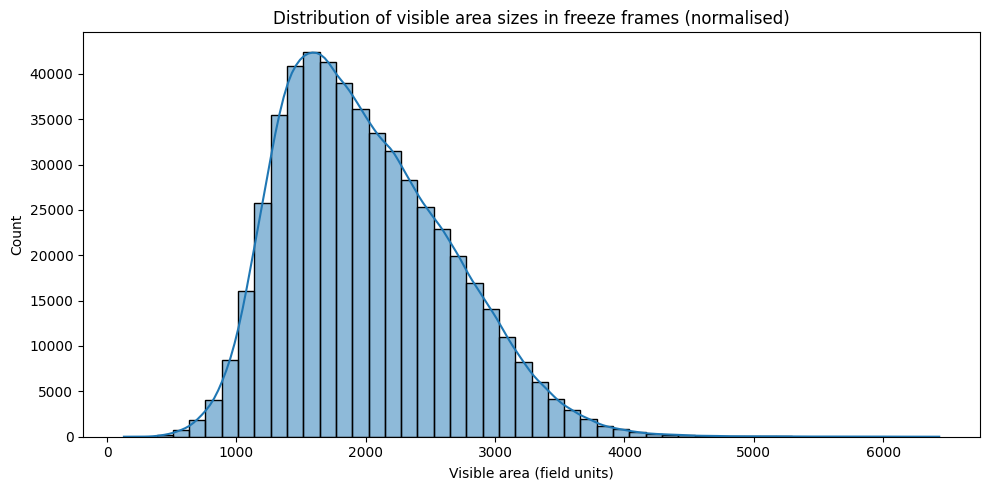

📐 Min : 130.30
📏 Max : 6433.67
📊 Moyenne : 2003.00
Nombre de freeze_frame avec visible_area > 8000 : 0


,game_id,period_id,time_seconds,visible_area_size,visible_area


In [123]:
# Seuil max : surface terrain (105 x 68 = 7140)
threshold_area = 8000

# Crée une colonne temporaire avec la surface visible
actions_360["visible_area_size"] = actions_360["visible_area"].apply(
    lambda poly: Polygon(np.array(poly).reshape(-1, 2)).area if isinstance(poly, list) else np.nan
)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(actions_360["visible_area_size"].dropna(), bins=50, kde=True)
plt.xlabel("Visible area (field units)")
plt.ylabel("Count")
plt.title("Distribution of visible area sizes in freeze frames (normalised)")
plt.tight_layout()
plt.show()

# Statistiques utiles
print(f"📐 Min : {actions_360['visible_area_size'].min():.2f}")
print(f"📏 Max : {actions_360['visible_area_size'].max():.2f}")
print(f"📊 Moyenne : {actions_360['visible_area_size'].mean():.2f}")
# Sélectionne les outliers
area_outliers = actions_360[actions_360["visible_area_size"] > threshold_area]
print(f"Nombre de freeze_frame avec visible_area > {threshold_area} : {len(area_outliers)}")

# Aperçu des anomalies
display(area_outliers[["game_id", "period_id", "time_seconds", "visible_area_size", "visible_area"]].head())


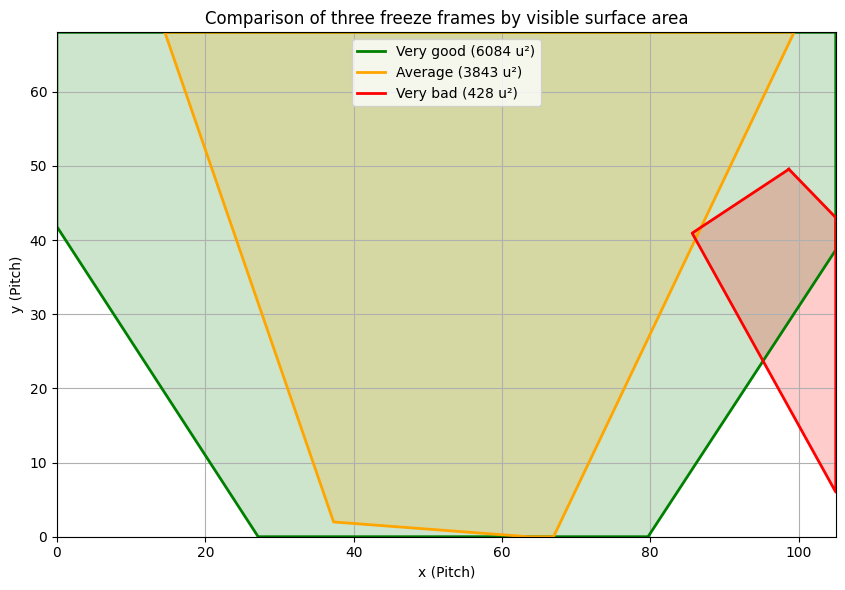

In [133]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np

# 👀 Sélection de 3 cas : bon, moyen, mauvais
# (à adapter selon tes seuils exacts ou selon un tri visuel)
examples = {
    "Very good": actions_360[actions_360["visible_area_size"] > 6000].iloc[0],
    "Average": actions_360[(actions_360["visible_area_size"] > 3000) & (actions_360["visible_area_size"] < 4000)].iloc[0],
    "Very bad": actions_360[actions_360["visible_area_size"] < 500].iloc[0],
}

# 🎨 Couleurs pour chaque type
colors = {
    "Very good": "green",
    "Average": "orange",
    "Very bad": "red",
}

# 🖼️ Tracé
plt.figure(figsize=(10, 6))
for label, row in examples.items():
    if isinstance(row["visible_area"], list):
        coords = np.array(row["visible_area"]).reshape(-1, 2)
        polygon = Polygon(coords)
        x, y = polygon.exterior.xy
        plt.plot(x, y, color=colors[label], linewidth=2, label=f"{label} ({row['visible_area_size']:.0f} u²)")
        plt.fill(x, y, alpha=0.2, color=colors[label])

# ⚙️ Mise en forme du terrain
plt.xlim(0, 105)
plt.ylim(0, 68)
plt.gca().set_aspect('equal')
plt.title("Comparison of three freeze frames by visible surface area")
plt.xlabel("x (Pitch)")
plt.ylabel("y (Pitch)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [134]:
from collections import Counter

# ➕ Nombre de joueurs visibles dans chaque freeze frame
def count_visible_players(ff):
    if isinstance(ff, list):
        return len(ff)
    return np.nan

# ➕ Nombre de coéquipiers (hors porteur)
def count_teammates(ff):
    if isinstance(ff, list):
        return sum(p["teammate"] and not p["actor"] for p in ff)
    return np.nan

# ➕ Nombre d’adversaires
def count_opponents(ff):
    if isinstance(ff, list):
        return sum(not p["teammate"] for p in ff)
    return np.nan

# ➕ Présence d’un acteur
def has_actor(ff):
    if isinstance(ff, list):
        return any(p["actor"] for p in ff)
    return False

# Application
actions_360["n_players_visible"] = actions_360["freeze_frame"].apply(count_visible_players)
actions_360["n_teammates"] = actions_360["freeze_frame"].apply(count_teammates)
actions_360["n_opponents"] = actions_360["freeze_frame"].apply(count_opponents)
actions_360["has_actor"] = actions_360["freeze_frame"].apply(has_actor)


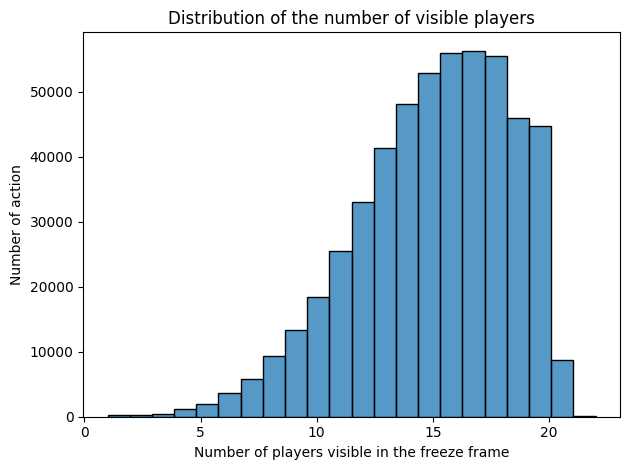

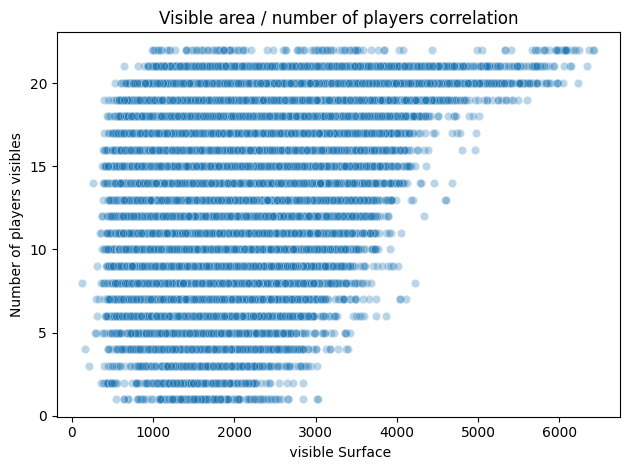

📈 Corrélation (Pearson) : 0.406
Nombre moyen de joueurs visibles : 15.195844408341035
Nombre moyen d’adversaires visibles : 7.647398545275014
Nombre moyen de coéquipiers visibles (hors porteur) : 6.548432467808325
Pourcentage d’actions avec porteur identifié : 86.36000066103684 %


In [136]:
sns.histplot(actions_360["n_players_visible"].dropna(), bins=22)
plt.xlabel("Number of players visible in the freeze frame")
plt.ylabel("Number of action")
plt.title("Distribution of the number of visible players")
plt.tight_layout()
plt.show()
sns.scatterplot(data=actions_360, x="visible_area_size", y="n_players_visible", alpha=0.3)
plt.xlabel(" visible Surface")
plt.ylabel("Number of players visibles")
plt.title("Visible area / number of players correlation")
plt.tight_layout()
plt.show()

corr = actions_360[["visible_area_size", "n_players_visible"]].corr().iloc[0,1]
print(f"📈 Corrélation (Pearson) : {corr:.3f}")
print("Nombre moyen de joueurs visibles :", actions_360["n_players_visible"].mean())
print("Nombre moyen d’adversaires visibles :", actions_360["n_opponents"].mean())
print("Nombre moyen de coéquipiers visibles (hors porteur) :", actions_360["n_teammates"].mean())
print("Pourcentage d’actions avec porteur identifié :", actions_360['has_actor'].mean() * 100, "%")
